In [1]:
import datetime
import locale

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting french locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

PLOT_VIGILO_RELEASE_DATE = True

sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.8)
blue, orange = sns.color_palette("muted", 2)

In [2]:
# Getting data
resp = requests.get('https://vigilo.jesuisundesdeux.org/get_issues.php')
df = pd.DataFrame(resp.json())
df.time = pd.to_datetime(df.time, unit='s')
df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)

# Filtering out data before 2019-01-01
df = df[df.time.apply(lambda x: x.year) > 2018]

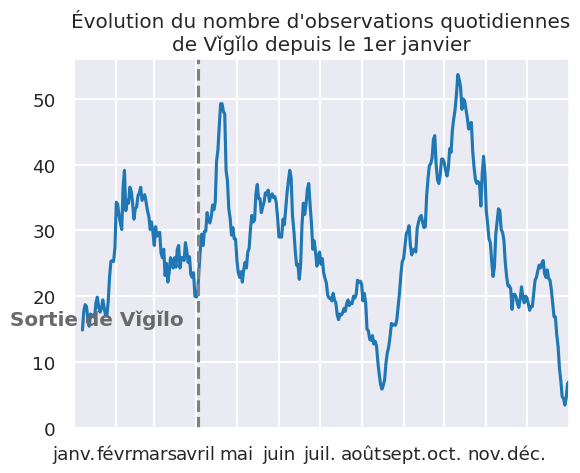

In [3]:
fig, ax = plt.subplots()

WINDOWS_SIZE = 7  # Smoothing window in days
count = df.groupby('julian_day').token.count()
count = pd.Series([count[x] if x in count.index else 0 for x in range(df.julian_day.min(), df.julian_day.max() + 1)],
                  range(df.julian_day.min(), df.julian_day.max() + 1))

count_smoothed = count.rolling(WINDOWS_SIZE).sum().apply(lambda x: x / WINDOWS_SIZE)

ax.plot(count_smoothed)

ticks = [datetime.datetime(year=2019, month=x, day=1).timetuple().tm_yday for x in range(1, 13)]
ticks_labels = [datetime.datetime(year=2019, month=x, day=1).strftime('%b') for x in range(1, 13)]
plt.xticks(ticks, ticks_labels)
ax.set_xlim(0, count_smoothed.dropna().index.max())

ylim = ax.get_ylim()
if PLOT_VIGILO_RELEASE_DATE:
    vigilo_release_date = datetime.datetime(year=2019, month=4, day=2).timetuple().tm_yday
    ax.plot((vigilo_release_date, vigilo_release_date), (0, 1000000), '--', color='grey')
    ax.text(x=vigilo_release_date,
            y=15,
            s='Sortie de Vǐgǐlo  ',
            horizontalalignment='right',
            verticalalignment='bottom',
            color='dimgrey',
            fontweight='bold')
ax.set_ylim(0, ylim[1])

plt.title("Évolution du nombre d'observations quotidiennes\nde Vǐgǐlo depuis le 1er janvier")

plt.show()